Can you make a heatmap of ns*S/N+ (1-ns/N)*B as a function of RA and DEC?
(you can use rectanuglar grid)
for the value of phi_0 where the hump is maximized
or maybe first just ns*S/N

PASUMARTI VIBHAVASU, Yesterday 1:59 PM
Sir, since S is summed over psr declinations , will this plot be valid?

Otherwise, should I generate the plot viz eqn 10 of 2103.12813 which we have decided against?

Shantanu Desai, Yesterday 2:02 PM
Sir, since S is summed over psr declinations , will this plot be valid?-> Right. But I think youc an do it as a function of neutrino RA and DEC right?

What I was thnking is that equation 1 is a product over all individual likelihoods
so le's look at individual likelihoods


Otherwise, should I generate the plot viz eqn 10 of 2103.12813 which we have decided against?-> Yes try that too as a function of pulsar RA & DEC to see if you get any insights from that


In [1]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda, float64, int64
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp
from scipy import integrate as scint
# import torch
# from core import weights

read icdata
read uptdata
read eadata
read mspdata


In [2]:
num_threads = int(mul.cpu_count()*0.8)
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
set_num_threads(num_threads)
PI = np.pi

# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

master_nbins = int(1e3)
# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.float64(np.logspace(11.001, 18.999, master_nbins))

decl_bins=lnu#master_nbins//1000
# decls = np.rad2deg(np.linspace(-np.pi/2, np.pi/2 - 1e-40, decl_bins))
decls = icdec


enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) - 1
    
    
decls_bin_indices = np.zeros(len(decls), dtype=np.int64)

for i in prange(decl_bins):
    decls_bin_indices[i] = np.digitize(decls[i], dec_nu) - 1

decls_bin_indices[-1] -= 1

decls = np.deg2rad(decls)

msdec_bin_indices = np.zeros(p, dtype=np.int64)
for i in prange(p):
    msdec_bin_indices[i] = np.digitize(msdec[i], dec_nu) - 1

gamma_arr = np.asfarray([-2, -2.2, -2.53, -3], dtype=np.float64)
np.digitize(np.array([0, 1, 2]), np.linspace(0, 11, 12))
@vectorize([float64(int64, int64, float64)], nopython=True, target='parallel')
def ns_newhat(decl_index, season, gamma):
    '''
    EQN 10 OF 2103.12813
    -------------------
    
    Parameters
    ----------
    decl_index : int64
        The index of the declination bin
    season : int64
        The index of the season
    gamma : float64
        The spectral index of the neutrino flux
    Returns
    -------
    float64
        The number of signal events for a single pulsar as in EQN10 of 2103.12813
    '''
    
    
    temp = dfde(enus, gamma, 1) * enus# * np.cos(decls[decl_index])
    temp2 = earea[ea_season(season)][(decls_bin_indices[decl_index] * 40 + enus_bin_indices).astype(np.int64)].astype(np.float64)
    temp = temp * temp2
    return np.trapz(temp, enus)

## EQN 10 of 2103.12813 done in the following cell

if f'all_ns_HAT_spl_{len(enus)}_x_{len(decls)}.pkl' in os.listdir(altier_path[0]):
    print("Loading ns_spl from pickle")
    with open(altier_path[0] + f'all_ns_HAT_spl_{len(enus)}_x_{len(decls)}.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded ns_spl from pickle")
    
    if f'all_ns_of_delta_spl_{len(enus)}_x_{len(decls)}.pkl' in os.listdir(altier_path[0]):
        print("Loading ns_of_delta_spl from pickle")
        with open(altier_path[0] + f'all_ns_of_delta_spl_{len(enus)}_x_{len(decls)}.pkl', 'rb') as f:
            ns_of_delta = pickle.load(f)
        print("Loaded ns_of_delta_spl from pickle")

else:
    print("Calculating ns_spl")
    ns_spl = []
    ns_of_delta = []
    for gamma in gamma_arr:
        ns_s_g = 0
        ns_of_delta_temp=[]
        for season in tqdm(prange(10)):
          
        
            temp = ns_newhat(prange(decl_bins), season, gamma)
            ns_of_delta_temp.append(temp)
            ns_s_g += t_upt[season]* np.trapz(temp, dx=np.diff(np.sin(decls))) * 2 * PI
        ns_of_delta.append(ns_of_delta_temp)
        ns_spl.append(ns_s_g)
    ns_spl = np.asfarray(ns_spl, dtype=np.float64)
    with open(altier_path[0] + f'all_ns_HAT_spl_{len(enus)}_x_{len(decls)}.pkl', 'wb') as f:
        pickle.dump(ns_spl, f)
        
    with open(altier_path[0] + f'all_ns_of_delta_spl_{len(enus)}_x_{len(decls)}.pkl', 'wb') as f:
        pickle.dump(ns_of_delta, f)
    
    arr = ns_spl
    print("Calculated and Saved ns_spl to pickle")

    


Loading ns_spl from pickle
Loaded ns_spl from pickle
Loading ns_of_delta_spl from pickle
Loaded ns_of_delta_spl from pickle


In [3]:
@njit(nogil=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2

In [4]:
dec_nu

array([-90.  , -73.74, -66.93, -61.64, -57.14, -53.13, -49.46, -46.05,
       -42.84, -39.79, -36.87, -34.06, -31.33, -28.69, -26.1 , -23.58,
       -21.1 , -18.66, -16.26, -13.89, -11.54,  -9.21,  -6.89,  -4.59,
        -2.29,   0.  ,   2.29,   4.59,   6.89,   9.21,  11.54,  13.89,
        16.26,  18.66,  21.1 ,  23.58,  26.1 ,  28.69,  31.33,  34.06,
        36.87,  39.79,  42.84,  46.05,  49.46,  53.13,  57.14,  61.64,
        66.93,  73.74,  90.  ])

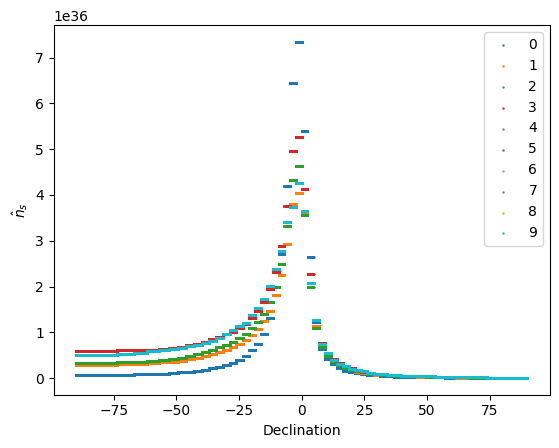

In [11]:

for season in range(10):
    plt.scatter(np.rad2deg(decls), ns_of_delta[0][season], s=0.5, label=season)
    
plt.xlabel('Declination')
plt.ylabel('$\hat{n}_s$')
plt.legend()
plt.show()

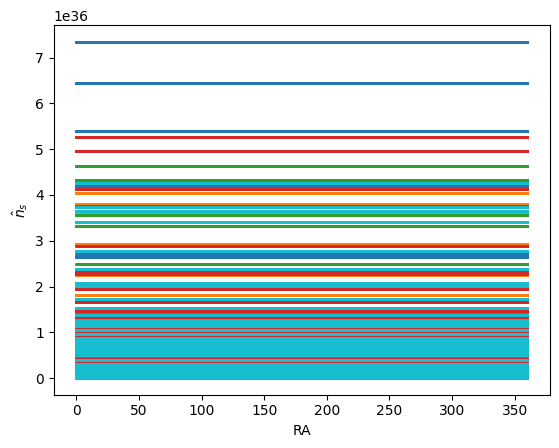

In [16]:

for season in range(10):
    plt.scatter(icra, ns_of_delta[0][season], s=1)
plt.xlabel('RA')
plt.ylabel('$\hat{n}_s$')
plt.show()

In [7]:
np.shape(ns_of_delta)

(4, 10, 1134450)

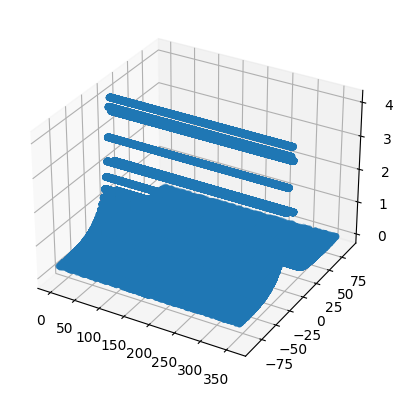

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x = icra
y = icdec
z = ns_of_delta[0][1]
ax.scatter(x, y, z, linewidth=0.15)
# meshx, meshy = np.meshgrid(x, y)
# ax.contour3D(meshx, meshy, z)


In [149]:
def foo(eee, ddd):
    e_ind = np.digitize(eee, e_nu_wall) - 1
    d_ind = np.digitize(ddd, dec_nu) - 1
    return earea[0][d_ind * 40 + e_ind]
    # return earea[0][decls_bin_indices[ddd] * 40 + enus_bin_indices[eee]]

In [224]:
len(dec_nu)

51

In [225]:
len(e_nu_wall)

41

In [267]:
t_upt.shape

(10,)

In [271]:
earea_wtd

array([0., 0., 0., ..., 0., 0., 0.])

In [286]:
earea_wtd = np.zeros(2000)
for i in range(10):
    earea_wtd += earea[ea_season(i)] * t_upt[i]/np.sum(t_upt)

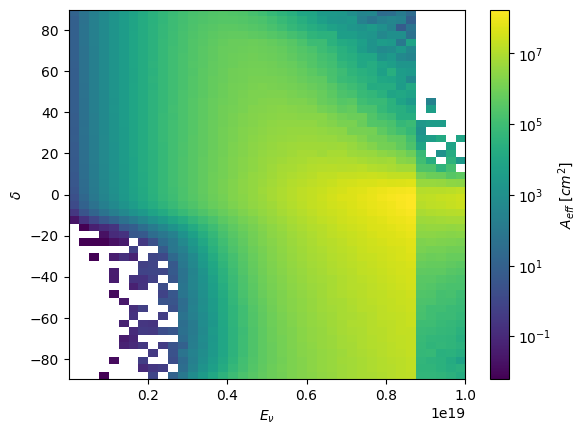

In [287]:

# Define the bin edges
# xedge = [1, 2, 3, 4, 5]  # X bin edges
# yedge = [0, 2, 4, 6]     # Y bin edges
xedge = e_nu_wall
yedge = dec_nu
# Define the counts
# counts = [[3, 2, 1],      # Counts for each bin
#           [1, 4, 2],
#           [0, 1, 3],
#           [2, 3, 1],
#           [1, 2, 0]]

counts = np.reshape(earea_wtd, (50, 40))
# counts = [earea[0][i:i+40] for i in range(0, 2000, 40)]


# Convert counts to a numpy array
counts = np.array(counts)

# Plot the 2D histogram
plt.imshow(counts, origin='lower', norm="log", extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], aspect='auto', cmap='viridis')
# plt.hist2d(xedge, yedge, bins=[xedge, yedge], weights=counts)

# Add labels and color bar
# plt.xscale('log')
plt.xlabel('$E_\u03BD$')
plt.ylabel('$\delta$')
plt.colorbar(label='$A_{eff}$ [$cm^2$]')

# Show the plot
plt.show()

In [245]:
counts.shape

(50, 40)

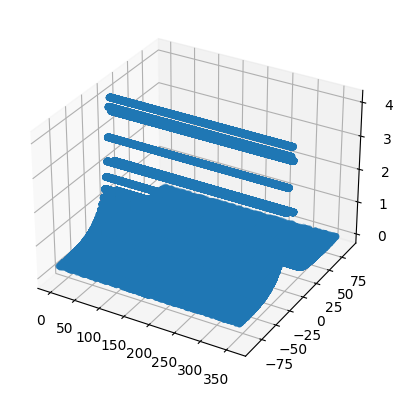

In [109]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x = icra
y = icdec
z = ns_of_delta[0][1]
ax.scatter(x, y, z, linewidth=0.15)

In [53]:
len(e_nu_wall)

41

plt.hist2d(list(e_nu_wall[:-1])*50, list(dec_nu[:-1])*40, weights=list(earea[0]), bins=[e_nu_wall, dec_nu])

In [55]:
len(list(e_nu_wall)*50)

2050

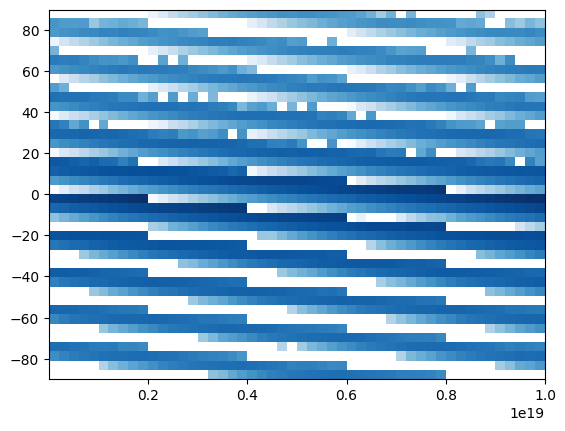

In [204]:
# x, y = np.meshgrid(range(len(dec_nu)-1) , range(len(e_nu_wall)-1))
# counts = np.reshape(earea[0], (len(e_nu_wall)-1, len(dec_nu)-1))

# # plt.contour(y, x,counts)
# plt.imshow(counts, origin='lower', extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], aspect='auto', cmap='Blues', norm="log")

In [ ]:
plt.hist2d(,weights= )

In [217]:
x, y = np.meshgrid(np.linspace(-90, 90, 100), np.logspace(11.001, 17.999, 100))

z = [foo(i, np.linspace(-90+1e-10, 90-1e-10, 100)) for i in np.logspace(11.001, 17.999, 100) ]

In [218]:
z[1]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 0.  , 0.  , 0.  , 0.35,
       0.  , 0.25, 0.25, 0.  , 0.19, 0.84, 0.84, 0.45, 0.22, 0.41, 0.41,
       0.26, 0.74, 0.74, 1.04, 0.  , 0.  , 0.46, 0.46, 0.79, 1.29, 1.29,
       1.15, 1.15, 0.52, 0.52, 2.1 , 2.1 , 2.1 , 1.58, 1.58, 1.58, 1.3 ,
       1.3 , 1.3 , 1.3 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 ,
       0.6 ])

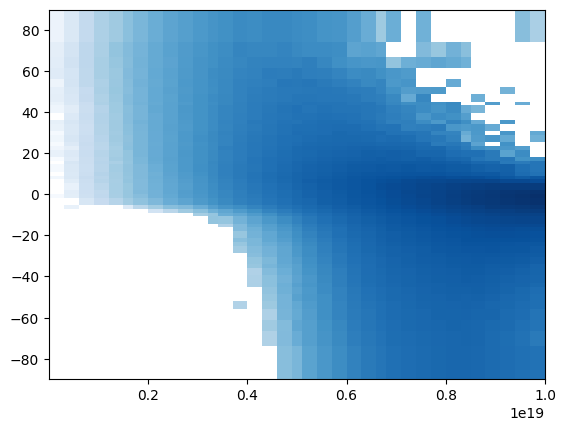

In [221]:
plt.imshow(np.transpose(z), origin='lower', extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], aspect='auto', cmap='Blues' ,norm="log")
# plt.yscale('log')
# plt.axis('')

In [178]:
z[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.13271000e+03, 1.13271000e+03,
       1.13271000e+03, 2.23667000e+03, 2.23667000e+03, 1.25089800e+04,
       1.25089800e+04, 1.25089800e+04, 3.53887600e+04, 3.53887600e+04,
      